*Filename* : Implement Resnet with onecyclepolicy  


*Test Accuracy* : (73.24%%)  
*Train Accuracy* : (71.82%)  
*Total params* : 6,573,130

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # , force_remount=True

Mounted at /content/gdrive


In [2]:
# install required packages
!pip install torch-lr-finder -q --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/balajib363/ERAV2.git
!mv ERAV2/session10/* .
import custom_resnet
import data_loader
import utils

Cloning into 'ERAV2'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 78 (delta 16), reused 65 (delta 5), pack-reused 0
Receiving objects: 100% (78/78), 2.95 MiB | 6.87 MiB/s, done.
Resolving deltas: 100% (16/16), done.


# import necessary packages

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

from data_loader import load_dataset

# Load dataset and perform augmentation

In [5]:
dataset_obj = load_dataset() # create dataset obj
cuda_status = dataset_obj.check_cuda()
batch_size = 512 if cuda_status else 64 # check for GPU
# load datasets for training and evaluation
train_loader, test_loader = dataset_obj.ret_datasets(batch_size, cuda_status)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:04<00:00, 40407920.06it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified
CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Display sample images

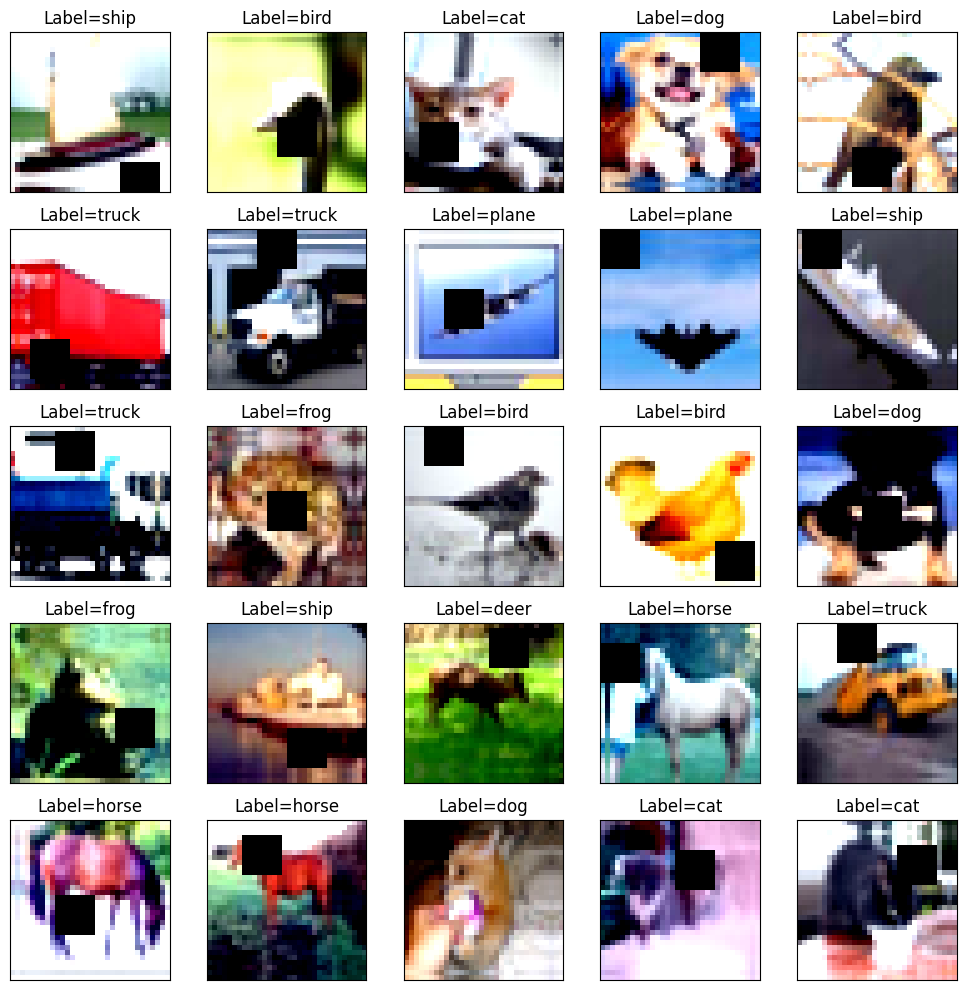

In [6]:
dataset_obj.display_sample_imgs(train_loader)

# Load Resnet model and print the model summary

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Loading Resnet Model
model_S10 = custom_resnet.Model_S10().to(device)

summary(model_S10, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
                 X-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1,

# LR finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.67E-03


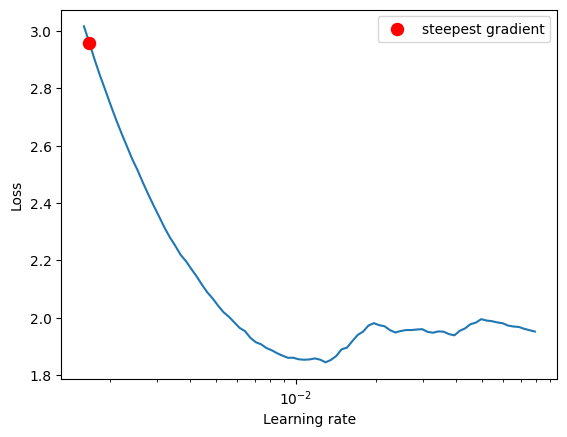

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.0016681005372000588)

In [8]:
model_S10 = custom_resnet.Model_S10().to(device)
optimizer = torch.optim.Adam(model_S10.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_S10, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=100)
lr_finder.plot()

# Set model params for training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_S10.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=0.003,
                                                steps_per_epoch=len(train_loader),
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                final_div_factor=25,
                                                anneal_strategy='linear'
                                                )

# Training

In [10]:
from utils import train, test

train = train()
test = test()
EPOCHS= 24

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  train.execute(model_S10, device, train_loader, optimizer, scheduler, criterion, epoch)
  test.execute(model_S10, device, test_loader, criterion)

Epoch: 0,Loss=1.10 Batch_id=97 Accuracy=49.53: 100%|██████████| 98/98 [00:19<00:00,  5.16it/s]


Test set: Average loss: 0.0027, Accuracy: 5232/10000 (52.32%)



Epoch: 1,Loss=0.76 Batch_id=97 Accuracy=65.67: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]


Test set: Average loss: 0.0029, Accuracy: 5364/10000 (53.64%)



Epoch: 2,Loss=0.73 Batch_id=97 Accuracy=73.91: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]


Test set: Average loss: 0.0022, Accuracy: 6466/10000 (64.66%)



Epoch: 3,Loss=0.57 Batch_id=97 Accuracy=78.16: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Test set: Average loss: 0.0017, Accuracy: 7207/10000 (72.07%)



Epoch: 4,Loss=0.60 Batch_id=97 Accuracy=81.27: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.0015, Accuracy: 7486/10000 (74.86%)



Epoch: 5,Loss=0.47 Batch_id=97 Accuracy=83.62: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]


Test set: Average loss: 0.0012, Accuracy: 8032/10000 (80.32%)



Epoch: 6,Loss=0.41 Batch_id=97 Accuracy=85.82: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.0014, Accuracy: 7584/10000 (75.84%)



Epoch: 7,Loss=0.35 Batch_id=97 Accuracy=87.74: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.0010, Accuracy: 8201/10000 (82.01%)



Epoch: 8,Loss=0.31 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Test set: Average loss: 0.0010, Accuracy: 8274/10000 (82.74%)



Epoch: 9,Loss=0.25 Batch_id=97 Accuracy=90.41: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.0009, Accuracy: 8470/10000 (84.70%)



Epoch: 10,Loss=0.23 Batch_id=97 Accuracy=91.45: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Test set: Average loss: 0.0011, Accuracy: 8217/10000 (82.17%)



Epoch: 11,Loss=0.19 Batch_id=97 Accuracy=92.40: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Test set: Average loss: 0.0007, Accuracy: 8693/10000 (86.93%)



Epoch: 12,Loss=0.20 Batch_id=97 Accuracy=93.43: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.0009, Accuracy: 8467/10000 (84.67%)



Epoch: 13,Loss=0.24 Batch_id=97 Accuracy=94.22: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Test set: Average loss: 0.0008, Accuracy: 8658/10000 (86.58%)



Epoch: 14,Loss=0.17 Batch_id=97 Accuracy=94.92: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.0008, Accuracy: 8711/10000 (87.11%)



Epoch: 15,Loss=0.15 Batch_id=97 Accuracy=95.58: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Test set: Average loss: 0.0007, Accuracy: 8819/10000 (88.19%)



Epoch: 16,Loss=0.11 Batch_id=97 Accuracy=96.21: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Test set: Average loss: 0.0007, Accuracy: 8847/10000 (88.47%)



Epoch: 17,Loss=0.08 Batch_id=97 Accuracy=96.92: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.0007, Accuracy: 8829/10000 (88.29%)



Epoch: 18,Loss=0.06 Batch_id=97 Accuracy=97.16: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0007, Accuracy: 8828/10000 (88.28%)



Epoch: 19,Loss=0.06 Batch_id=97 Accuracy=97.59: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0008, Accuracy: 8745/10000 (87.45%)



Epoch: 20,Loss=0.04 Batch_id=97 Accuracy=98.02: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Test set: Average loss: 0.0007, Accuracy: 8859/10000 (88.59%)



Epoch: 21,Loss=0.04 Batch_id=97 Accuracy=98.39: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0007, Accuracy: 8828/10000 (88.28%)



Epoch: 22,Loss=0.05 Batch_id=97 Accuracy=98.51: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


Test set: Average loss: 0.0007, Accuracy: 8860/10000 (88.60%)



Epoch: 23,Loss=0.06 Batch_id=97 Accuracy=98.74: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]


Test set: Average loss: 0.0007, Accuracy: 8858/10000 (88.58%)



# Display misclassified images

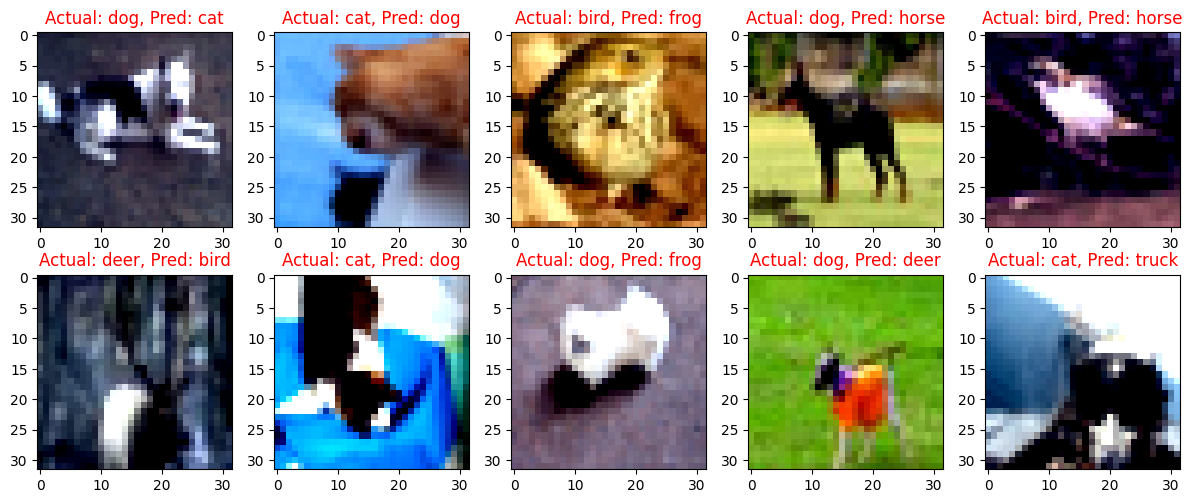

In [11]:
utils.plot_misclassified_imgs(model_S10, test_loader, device)

# Plot training metrics

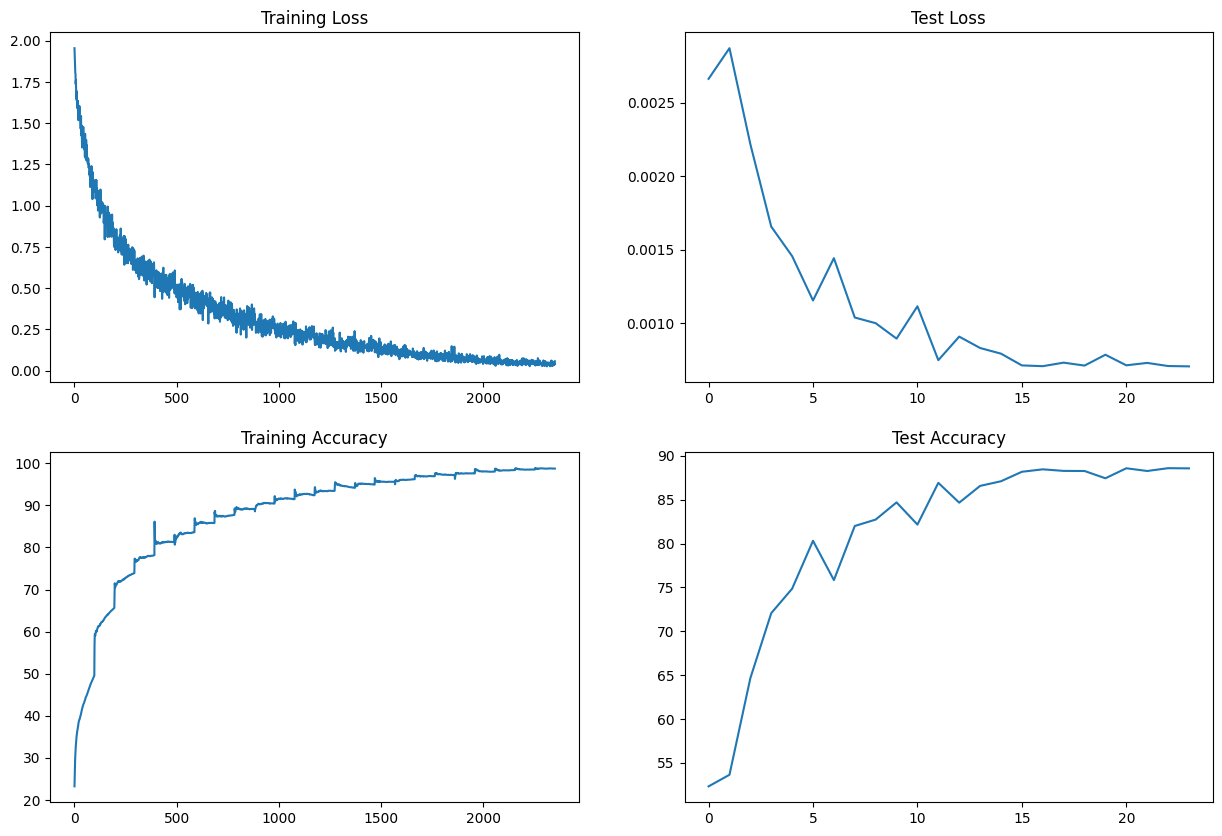

In [12]:
utils.plot_training_metrics(train, test)